In [1]:
import torch
#from controlnet_aux import CannyDetector
from diffusers import FluxControlPipeline
from diffusers import FluxKontextPipeline
from diffusers.utils import load_image

from transformers import AutoImageProcessor, AutoModelForDepthEstimation

from huggingface_hub import notebook_login
from PIL import Image, ImageOps
from fastcore.xtras import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cvzone.SelfiSegmentationModule import SelfiSegmentation
import cv2

import logging
logging.disable(logging.WARNING)

torch.manual_seed(1)
#if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

/Users/sbrewer/anaconda3/envs/sd3pt5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def image_grid(imgs, rows, cols):
    #assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [3]:
def resize_with_padding(img_path, target_size, fill_color=(0, 0, 0), rotate=None):
    """
    Resize an image to fit within target_size by padding while maintaining aspect ratio.
    
    Args:
        img_path (str): Path to the input image.
        target_size (tuple): (width, height) for the target size.
        fill_color (tuple): RGB color for padding. Default is black.
    
    Returns:
        PIL.Image: New image with padding.
    """
    img = Image.open(img_path).convert("RGB")
    if rotate is not None: 
        img = img.rotate(rotate, expand=True)
    
    original_ratio = img.width / img.height
    target_ratio = target_size[0] / target_size[1]

    # Resize the image maintaining aspect ratio
    if original_ratio > target_ratio:
        # Image is wider
        new_width = target_size[0]
        new_height = round(target_size[0] / original_ratio)
    else:
        # Image is taller
        new_height = target_size[1]
        new_width = round(target_size[1] * original_ratio)

    img_resized = img.resize((new_width, new_height), Image.LANCZOS)

    # Add padding to reach the target size
    delta_w = target_size[0] - new_width
    delta_h = target_size[1] - new_height
    padding = (
        delta_w // 2,
        delta_h // 2,
        delta_w - (delta_w // 2),
        delta_h - (delta_h // 2)
    )
    new_img = ImageOps.expand(img_resized, padding, fill_color)
    
    return new_img

In [4]:
path_mdl='/Users/sbrewer/.cache/huggingface/hub/models--black-forest-labs--FLUX.1-dev/snapshots/3de623fc3c33e44ffbe2bad470d0f45bccf2eb21'
pipe = FluxControlPipeline.from_pretrained(path_mdl, torch_dtype=torch.bfloat16).to("mps")
path_w8="/Users/sbrewer/.cache/huggingface/hub/models--black-forest-labs--FLUX.1-Depth-dev-lora/snapshots/ee9cc283d790a079d549ac0bf9ef7183082e3d90"
pipe.load_lora_weights(path_w8, adapter_name="depth")
pipe.set_adapters("depth", 0.85)

Loading pipeline components...: 100%|█████████████| 7/7 [00:00<00:00, 10.58it/s]


In [5]:
# load image
img_test_path=Path('.').cwd()
image=resize_with_padding(img_test_path/'V4.jpeg', (512, 512), fill_color=(255, 255, 255))
img = np.array(image)

In [6]:
# predict depth image
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

# prepare image for the model
inputs = image_processor(images=img, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# interpolate to original size
post_processed_output = image_processor.post_process_depth_estimation(
    outputs,
    target_sizes=[(image.height, image.width)],
)

# visualize the prediction
predicted_depth = post_processed_output[0]["predicted_depth"]
depth = predicted_depth * 255 / predicted_depth.max()
depth = depth.detach().cpu().numpy()
control_image = Image.fromarray(depth.astype("uint8")).convert('RGB')

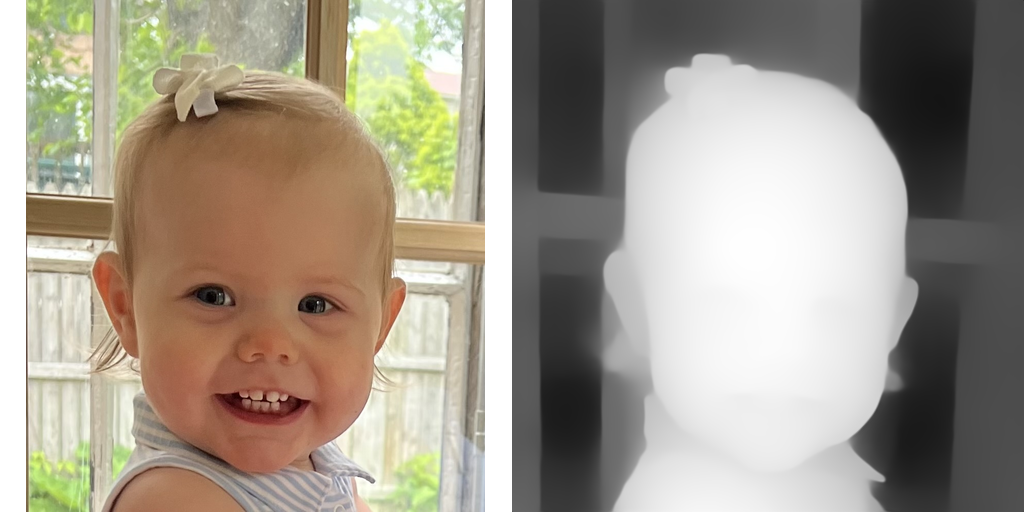

In [7]:
images=[image, control_image]
image_grid(images, 1, 2)

In [8]:
prompt =  """portrait of a baby /toddler, 1-year-old caucasian girl, dark blue eyes, scraggly short blonde hair in a white bow, 

"""


In [9]:
output_image = pipe(
    prompt=prompt,
    control_image=control_image,
    height=512,
    width=512,
    num_inference_steps=30,
    guidance_scale=10.0,
    generator=torch.Generator().manual_seed(0),
).images[0]

100%|███████████████████████████████████████████| 30/30 [02:02<00:00,  4.09s/it]


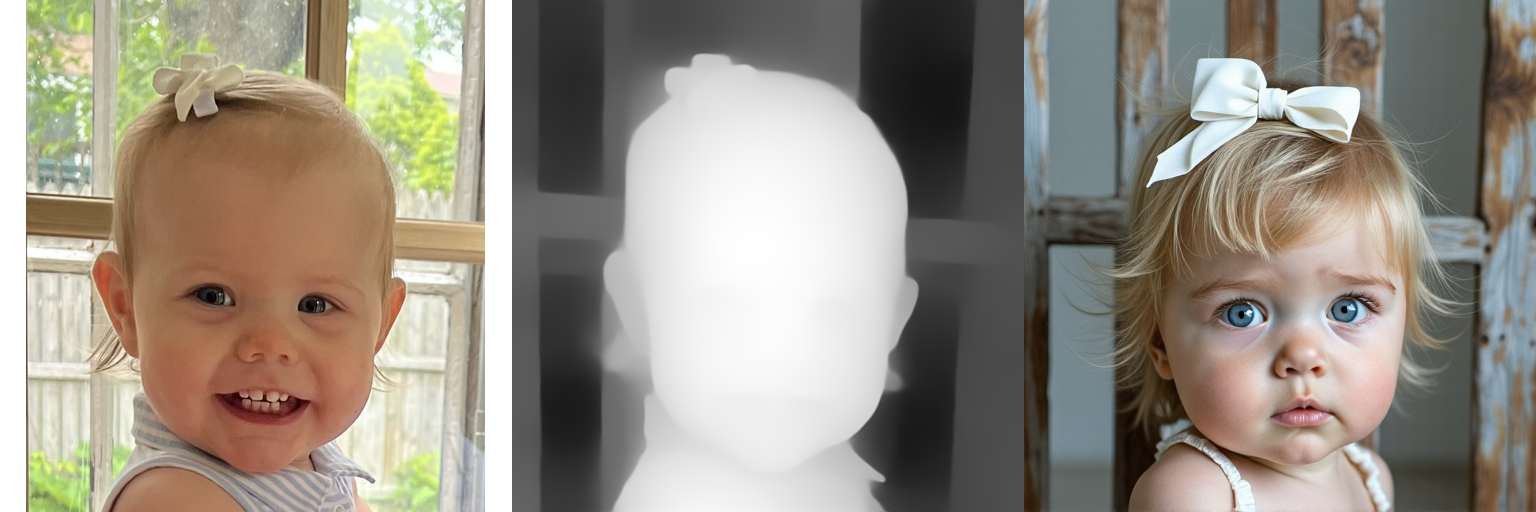

In [10]:
images=[image, control_image, output_image]
image_grid(images, 1, 3)

In [18]:
# segment model to remove background
seg = SelfiSegmentation()
img_bgrm = Image.fromarray(seg.removeBG(np.array(image), (255,255,255)))  # or any background color
output_img_bgrm = Image.fromarray(seg.removeBG(np.array(output_image), (255,255,255)))  # or any background color

I0000 00:00:1754140385.060901  117350 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2 Max
W0000 00:00:1754140385.066131  121147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [41]:
img1=np.array(image.convert('L'))
img2=np.array(output_image.convert('L'))

#img1=np.array(img_bgrm.convert('L'))
#img2=np.array(output_img_bgrm.convert('L'))

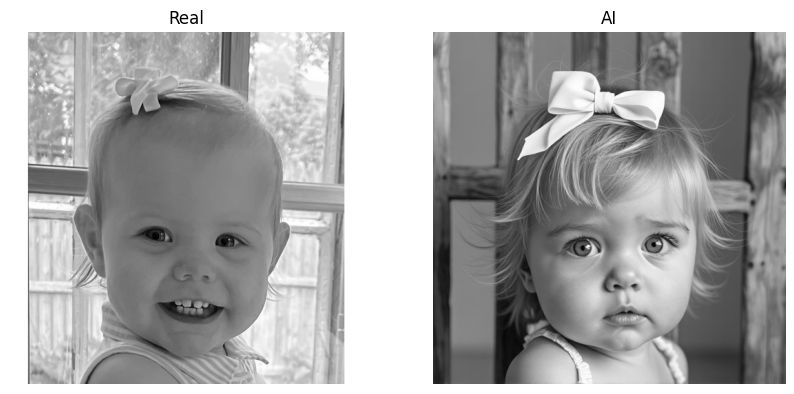

In [42]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Real")
plt.imshow(img1, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("AI")
plt.imshow(img2, cmap='gray')
plt.axis('off')

plt.show()

In [43]:
# ORB (free and fast) or use SIFT 
kp_dtct = cv2.SIFT_create() # or orb = cv2.ORB_create()   
kp1, des1 = kp_dtct.detectAndCompute(img1, None)
kp2, des2 = kp_dtct.detectAndCompute(img2, None)

In [66]:
# Draw keypoints
def draw_kp(img_gray, keypoints, color=(0, 255, 0)):
    img_color = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    img_with_kp = cv2.drawKeypoints(
        image=img_color,
        keypoints=keypoints,
        outImage=None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
        color=color
    )
    
    # Convert to PIL to display in Jupyter 
    img_result = Image.fromarray(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))
    return img_result


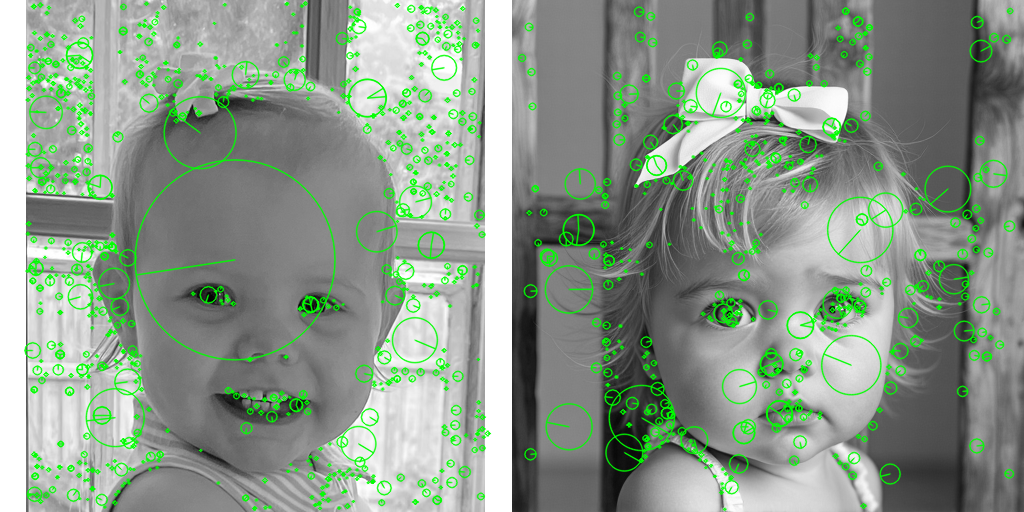

In [45]:
image_grid([draw_kp(img1, kp1),draw_kp(img2, kp2)], 1, 2)

In [46]:
des1.shape, des2.shape

((905, 128), (566, 128))

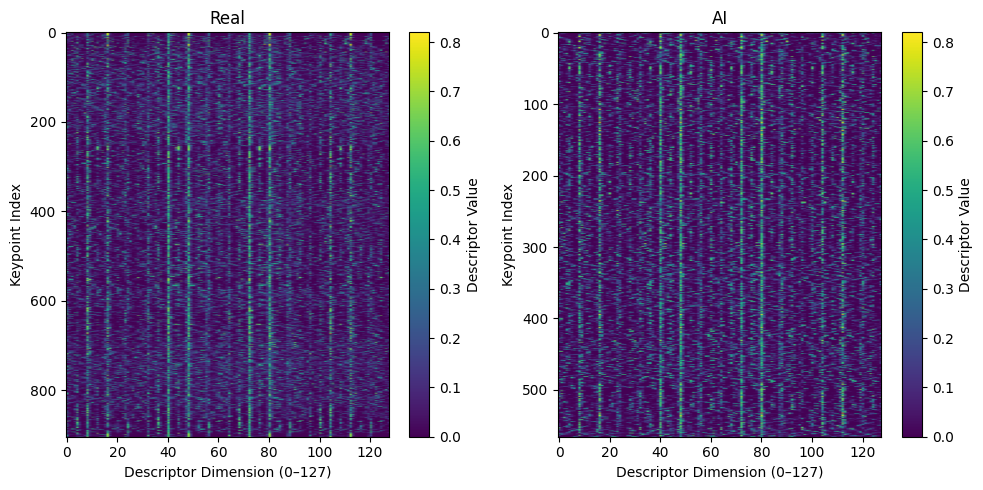

In [65]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(des1/255, aspect='auto', cmap='viridis')
plt.title("Real")
plt.colorbar(label='Descriptor Value')
plt.xlabel('Descriptor Dimension (0–127)')
plt.ylabel('Keypoint Index')

plt.subplot(1, 2, 2)
plt.imshow(des2/255, aspect='auto', cmap='viridis')
plt.title("AI")
plt.colorbar(label='Descriptor Value')
plt.xlabel('Descriptor Dimension (0–127)')
plt.ylabel('Keypoint Index')
plt.tight_layout()
plt.show()

In [48]:
np.concatenate([des1,des2]).shape

(1471, 128)

In [49]:
X=np.concatenate([des1,des2])/255
y=[0]*len(des1)+[1]*len(des2)

In [62]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2)

# Define and train model
clf = MLPClassifier(hidden_layer_sizes=(512, 256, 128), max_iter=500, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       193
           1       0.59      0.64      0.61       102

    accuracy                           0.72       295
   macro avg       0.69      0.70      0.70       295
weighted avg       0.73      0.72      0.72       295



In [ ]:
# TODO show what points are flagged as anomalous
# Eric's feedback, keypoints change too much between images, 
# Need to isolate keypoints so they are the same-ish image to image
# Images comparison should be a photo-realistic
# Do lit review to see what they are doing now
# get with Secure AI Lab (Marissa) + Dom about deepfake detection
# 
# Why this keypoint technique:
# * Good for large images
# * "explainable"
# * image classification model compresses out the ai-gen-ness

In [ ]:
## Why this over an image classifier?
* "Explainability"
* only part of an image my be altered. this highlights that region

In [63]:
import datetime as dt
end=dt.datetime.now()
print(f'Finished: {end.strftime("%A %B %d, %Y")} at {end.strftime("%H:%M")}')

Finished: Saturday August 02, 2025 at 09:28
